# Procesado de modelos 3D

In [1]:
# Imports
import trimesh
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import pyvista as pv
from PIL import Image
import vtk

2023-12-26 14:43:25.487169: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 14:43:25.734443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-26 14:43:25.734503: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-26 14:43:25.737568: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-26 14:43:25.875808: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 14:43:25.877482: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

### Funciones auxiliares

Función para sacar una imagen 2D dado un objeto en 3D

In [2]:
def take_screenshot(actors, plane, colors = None, textures = None, position = None, window_size = [1024, 768]):
    
    if position is None:
        position = [0.0, 0.0, 0.0]

        if plane.lower() == "xy" or plane.lower() == "yx":
            position[2] = 1000.0
        elif plane.lower() == "yz" or plane.lower() == "zy":
            position[0] = 1000.0
        elif plane.lower() == "xz" or plane.lower() == "zx":
            position[1] = 1000.0 
        else:
            print("ERROR: Wrong plane", plane)
            exit(1)
        

    plotter = pv.Plotter(off_screen = True, window_size = window_size)
    plotter.set_background("white")

    if colors is None:
        colors = [None] * len(actors)

    if textures is None:
        textures = [None] * len(actors)

    for actor, color, tex  in zip(actors, colors, textures):
        _ = plotter.add_mesh(actor, color = color, texture = tex)

    plotter.set_position(position)
    plotter.set_focus([0.0, 0.0, 0.0])
    plotter.enable_parallel_projection()
    plotter.parallel_scale = 200

    return np.array(plotter.screenshot()), plotter

Función para pasar punto 2D a punto 3D

In [3]:
def convert_2d_point_to_3d(pv_mesh, point, plotter):
    
    coordinate = vtk.vtkCoordinate()
    coordinate.SetCoordinateSystemToNormalizedDisplay()

    # the system coordinates is normalized, so 0.5 is the half of the image
    coordinate.SetValue(point[0], point[1])
    world_point = coordinate.GetComputedWorldValue(plotter.renderer)

    start = [world_point[0], -world_point[1], 1000]
    end = [world_point[0], -world_point[1], -1000]

    points, _ = pv_mesh.ray_trace(start, end)

    final_point = None

    if len(points) > 0:
        final_point = points[0]

    return final_point

### Obtener puntos clave modelo referencia

Cargamos el modelo de referencia 3D

In [4]:
# Ruta del archivo .obj
obj_file_path = 'H3DS-net/full_head.obj'
texture_file_path = 'H3DS-net/full_head.png'

# Importar la malla desde el archivo .obj
pv_mesh = pv.read(obj_file_path)

# Leer la textura desde el archivo de imagen
texture = pv.read_texture(texture_file_path)

# Llamar a la función take_screenshot
screenshot, plotter = take_screenshot([pv_mesh], plane='xy', textures=[texture])

# Convertir la captura de pantalla (matriz NumPy) a una imagen de Pillow
image = Image.fromarray(np.uint8(screenshot))

# Guardar la imagen en un archivo de imagen
image.save('modelo_referencia.png')

Cargamos la imagen 2D

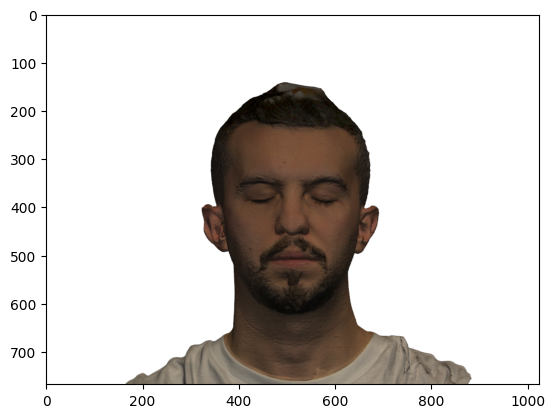

In [5]:
# Especifica el nombre del archivo para lectura de datos
imagen = 'modelo_referencia.png'

# Leer la imagen
img = cv2.imread(imagen)

# Muestra la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

Calculamos los puntos clave de la cara

I0000 00:00:1703598214.115146   14709 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1703598214.121186   14783 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.0.4-0ubuntu1~22.04.1), renderer: AMD Radeon Vega 8 Graphics (raven, LLVM 15.0.7, DRM 3.49, 6.2.0-32-generic)
W0000 00:00:1703598214.123055   14709 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


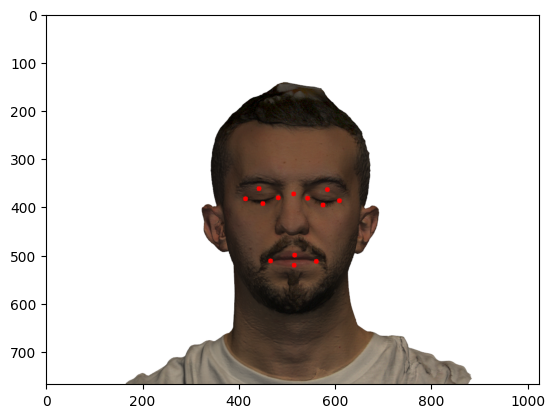

In [6]:
# Crear un objeto FaceLandmarker
base_options = python.BaseOptions(model_asset_path='face_landmarker.task')
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       running_mode=VisionRunningMode.IMAGE,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# Cargar la imagen
image = mp.Image.create_from_file(imagen)

# Detectar los face landmarks de la imagen
detection_result = detector.detect(image)

# Lista de índices de landmarks para nariz, ojos y boca
landmark_indices = [130, 27, 243, 23, 463, 257, 359, 253, 168, 61, 11, 291, 16]

# Dibujar solo los landmarks específicos en la imagen
annotated_image = image.numpy_view().copy()
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        h, w, _ = annotated_image.shape
        cx, cy = int(landmark.x * w), int(landmark.y * h)
        cv2.circle(annotated_image, (cx, cy), 5, (255, 0, 0), -1)

# Muestra la imagen con los landmarks seleccionados
plt.imshow(annotated_image)
plt.show()

Guardamos los landmarks elegidos

In [7]:
puntos_ref = []
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        # Crear un vector con las coordenadas x, y, z
        punto_3d = [landmark.x, landmark.y, landmark.z]
        # Agregar el vector a la lista
        puntos_ref.append(punto_3d)

In [8]:
coordenadas_2d_ref = [(x, y) for x, y, _ in puntos_ref]

coordenadas_3d_ref = []

for point in coordenadas_2d_ref:
    # Convertir cada punto 2D a 3D utilizando la función proporcionada
    converted_point = convert_2d_point_to_3d(pv_mesh, point, plotter)

    # Agregar el punto convertido a la lista
    coordenadas_3d_ref.append(converted_point)

# Invertir el valor de la coordenada y en cada punto
coordenadas_3d_ref = [(x, y, z) for x, y, z in coordenadas_3d_ref]
    
print("Coordenadas 3D resultantes:", coordenadas_3d_ref)

Coordenadas 3D resultantes: [(-50.535995, 0.12711287, -17.447363), (-36.389015, 11.032248, -1.3348794), (-15.461413, 1.2884259, -4.4633584), (-32.29154, -5.1018715, -8.179023), (16.348997, 0.66007376, -4.3715014), (37.74045, 10.050893, -1.7948587), (50.77203, -1.9906521, -16.822512), (32.82299, -6.5261364, -6.097302), (1.393191, 5.5720925, 12.625529), (-23.518053, -66.90862, 2.458813), (2.1766026, -60.613464, 17.643604), (25.888952, -67.48111, 2.9253252), (1.8618902, -71.569534, 15.830459)]


In [9]:
output_path = "modelo_referencia.pp"
with open(output_path, "w") as f:
    f.write("<!DOCTYPE PickedPoints>\n")
    f.write("<PickedPoints>\n")
    i = 0
    for idx in coordenadas_3d_ref:
        x, y, z = idx[0], idx[1], idx[2]
        f.write(
            '<point x="{}" y="{}" z="{}" active="1" name="{}" />\n'.format(
                x, y, z, i
            )
        )
        i += 1
    f.write("</PickedPoints>")

### Obtener matriz de transformación para otro modelo

In [10]:
# Ruta del archivo .obj
obj_file_path = 'HeadSpace/130929144738.obj'
texture_file_path = 'HeadSpace/130929144738.bmp'

# Importar la malla desde el archivo .obj
pv_mesh2 = pv.read(obj_file_path)

# Leer la textura desde el archivo de imagen
texture2 = pv.read_texture(texture_file_path)

# Llamar a la función take_screenshot
screenshot, plotter = take_screenshot([pv_mesh2], plane='xy', textures=[texture2])

# Convertir la captura de pantalla (matriz NumPy) a una imagen de Pillow
image = Image.fromarray(np.uint8(screenshot))

# Guardar la imagen en un archivo de imagen
image.save('modelo_objetivo.png')

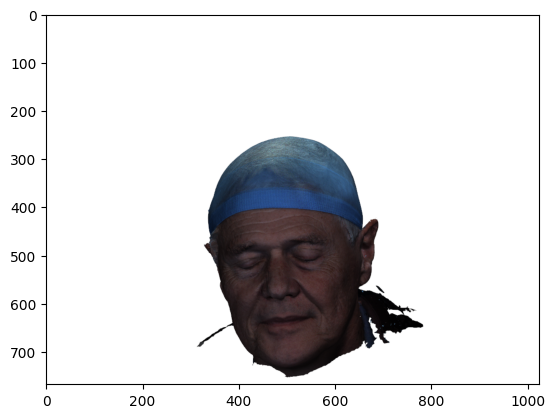

In [11]:
# Especifica el nombre del archivo para lectura de datos
imagen2 = 'modelo_objetivo.png'

# Leer la imagen
img = cv2.imread(imagen2)

# Muestra la imagen
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

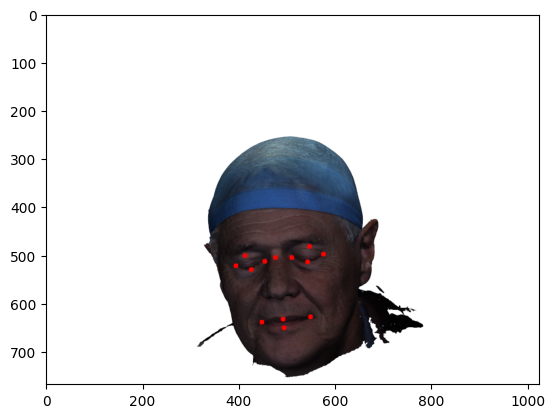

In [12]:
# Cargamos la imagen
image2 = mp.Image.create_from_file(imagen2)

# Detectamos los face landmarks de la imagen
detection_result = detector.detect(image2)

# Dibuja solo los landmarks específicos en la imagen
annotated_image = image2.numpy_view().copy()
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        h, w, _ = annotated_image.shape
        cx, cy = int(landmark.x * w), int(landmark.y * h)
        cv2.circle(annotated_image, (cx, cy), 5, (255, 0, 0), -1)

# Muestra la imagen con los landmarks seleccionados
plt.imshow(annotated_image)
plt.show()

In [13]:
puntos_obj = []
for face_landmarks in detection_result.face_landmarks:
    for idx in landmark_indices:
        landmark = face_landmarks[idx]
        # Crear un vector con laspuntos_ref coordenadas x, y, z
        punto_3d = [landmark.x, landmark.y, landmark.z]
        # Agregar el vector a la lista
        puntos_obj.append(punto_3d)

In [14]:
coordenadas_2d_obj = [(x, y) for x, y, _ in puntos_obj]
print(coordenadas_2d_obj)
coordenadas_3d_obj = []

for point in coordenadas_2d_obj:
    # Convertir cada punto 2D a 3D utilizando la función proporcionada
    converted_point = convert_2d_point_to_3d(pv_mesh2, point, plotter)
    print(converted_point)
    # Agregar el punto convertido a la lista
    coordenadas_3d_obj.append(converted_point)

# Filtrar las coordenadas 3D que son None
# coordenadas_3d_obj = [coord for coord in coordenadas_3d_obj if coord is not None]

# Invertir el valor de la coordenada y en cada punto
coordenadas_3d_obj = [(x, y, z) for x, y, z in coordenadas_3d_obj]
    
print("Coordenadas 3D resultantes:", coordenadas_3d_obj)

[(0.38543781638145447, 0.6809287071228027), (0.40339457988739014, 0.6529740691184998), (0.44367551803588867, 0.6684924960136414), (0.41691854596138, 0.6906257271766663), (0.4981785714626312, 0.6585157513618469), (0.5343271493911743, 0.6286666989326477), (0.5631675720214844, 0.6494101285934448), (0.5305396914482117, 0.6705673336982727), (0.4652692973613739, 0.6578576564788818), (0.43834927678108215, 0.8332692980766296), (0.48076075315475464, 0.8252483606338501), (0.5362240672111511, 0.8188380599021912), (0.4831695258617401, 0.8480656147003174)]
[-61.09983 -72.37148  84.47745]
[-51.522892 -61.18963  100.87338 ]
[-30.039724 -67.396996  99.31373 ]
[-44.31011 -76.25029  96.81971]
[ -0.9714286 -63.4063    102.988495 ]
[ 18.307814 -51.46668  110.646645]
[ 33.689373 -59.76405   98.986305]
[ 16.287836 -68.22694  105.78127 ]
[-18.52304  -63.143063 115.71594 ]
[ -32.880386 -133.30772    88.477516]
[ -10.260932 -130.09935   110.13573 ]
[  19.319502 -127.535225   94.12496 ]
[  -8.976253 -139.22624 

In [15]:
output_path = "modelo_objetivo.pp"
with open(output_path, "w") as f:
    f.write("<!DOCTYPE PickedPoints>\n")
    f.write("<PickedPoints>\n")
    i = 0
    for idx in coordenadas_3d_obj:
        x, y, z = idx[0], idx[1], idx[2]
        f.write(
            '<point x="{}" y="{}" z="{}" active="1" name="{}" />\n'.format(
                x, y, z, i
            )
        )
        i += 1
    f.write("</PickedPoints>")

In [16]:
# Llamar a la función take_screenshot
screenshot, plotter = take_screenshot([pv_mesh, pv_mesh2], plane='xy', textures=[texture, texture2])

# Convertir la captura de pantalla (matriz NumPy) a una imagen de Pillow
image = Image.fromarray(np.uint8(screenshot))

# Guardar la imagen en un archivo de imagen
image.save('modelos_sin_transformar.png')

Registramos de puntos referencia y objetivo

In [17]:
print(coordenadas_3d_ref)
print(coordenadas_3d_obj)
print(type(coordenadas_3d_ref))

v0 = list(zip(*coordenadas_3d_ref))
v1 = list(zip(*coordenadas_3d_obj))
matriz_transformacion = trimesh.transformations.affine_matrix_from_points(v0, v1, shear=False,scale=False)

matriz_transformacion[2][3] *= -1
matriz_transformacion[1][3] *= -1
matriz_transformacion[0][3] *= -1

print(matriz_transformacion)

[(-50.535995, 0.12711287, -17.447363), (-36.389015, 11.032248, -1.3348794), (-15.461413, 1.2884259, -4.4633584), (-32.29154, -5.1018715, -8.179023), (16.348997, 0.66007376, -4.3715014), (37.74045, 10.050893, -1.7948587), (50.77203, -1.9906521, -16.822512), (32.82299, -6.5261364, -6.097302), (1.393191, 5.5720925, 12.625529), (-23.518053, -66.90862, 2.458813), (2.1766026, -60.613464, 17.643604), (25.888952, -67.48111, 2.9253252), (1.8618902, -71.569534, 15.830459)]
[(-61.09983, -72.37148, 84.47745), (-51.522892, -61.18963, 100.87338), (-30.039724, -67.396996, 99.31373), (-44.31011, -76.25029, 96.81971), (-0.9714286, -63.4063, 102.988495), (18.307814, -51.46668, 110.646645), (33.689373, -59.76405, 98.986305), (16.287836, -68.22694, 105.78127), (-18.52304, -63.143063, 115.71594), (-32.880386, -133.30772, 88.477516), (-10.260932, -130.09935, 110.13573), (19.319502, -127.535225, 94.12496), (-8.976253, -139.22624, 109.09181)]
<class 'list'>
[[   0.98320595   -0.14437482   -0.11163321   16.839

In [18]:
pv_mesh2.transform(matriz_transformacion)
# Llamar a la función take_screenshot
screenshot, plotter = take_screenshot([pv_mesh, pv_mesh2], plane='xy', textures=[texture, texture2])

# Convertir la captura de pantalla (matriz NumPy) a una imagen de Pillow
image = Image.fromarray(np.uint8(screenshot))

# Guardar la imagen en un archivo de imagen
image.save('modelos_transformados.png')

### Problemas

- No coge bien la traslación en el eje Z (la profundidad). Creo que puede ser por la detección de puntos en la imagen 2D